In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [77]:
data = pd.read_csv('dataset-registros.csv')
data = data[data['cod_pais'].str.startswith('PE')].reset_index(drop=True).dropna(how='any')
data.head()

,cod_periodo,cod_pais,total_facturas
0,20230101,PE,18735
1,20230201,PE,17168
2,20230301,PE,19303
3,20230401,PE,16938
4,20230501,PE,18901


In [78]:
df = data['total_facturas']
df.head()

0    18735
1    17168
2    19303
3    16938
4    18901
Name: total_facturas, dtype: int64

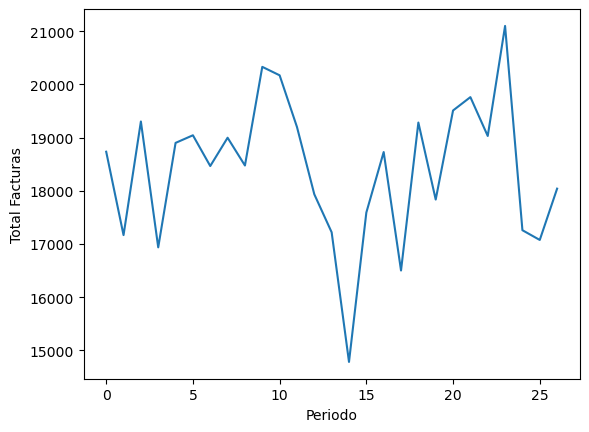

In [79]:
df.plot()
plt.xlabel('Periodo')
plt.ylabel('Total Facturas')
plt.show()

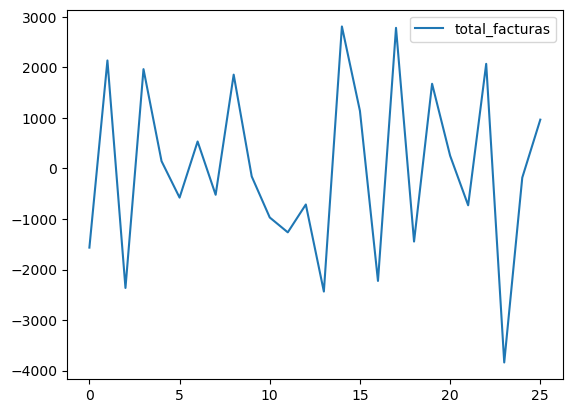

In [80]:
# aplicando una diferencia de primer orden
dif1 = df.diff()

# eliminando el primer registro: NaN
dif1 = dif1.dropna()
dif1 = dif1.reset_index().drop(columns=['index'])

# Graficar la serie temporal
dif1.plot()
plt.show()

Los lags no deben ser mayores a la mitad de la muestra

In [81]:
len(df)

27

- ACF (Autocorrelación)	MA(q) (Media Móvil)	Corta en el lag q
- PACF (Autocorrelación Parcial)	AR(p) (Autorregresivo)	Corta en el lag p

Resumen de diferencia entre ACF y PACF 

- **ACF** incluye tanto la relación directa como indirecta → sirve para identificar efectos de **medias móviles (MA)**.
- **PACF** elimina el efecto de los lags intermedios → muestra solo la relación pura → ideal para identificar **componentes autoregresivos (AR)**.

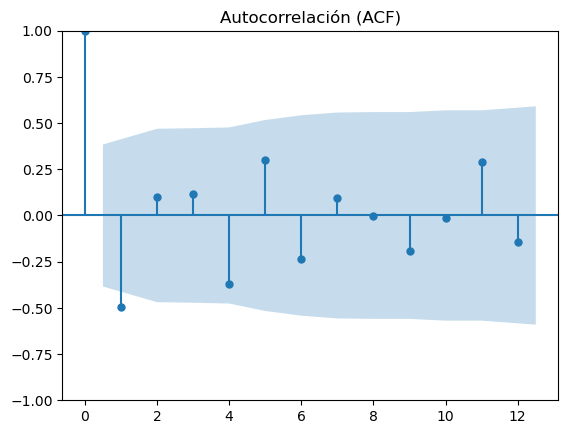

In [82]:
# Graficar la autocorrelación (ACF)
plot_acf(dif1, lags=12) # Se toma 12 para ver estacionalidad anual
plt.title('Autocorrelación (ACF)')
plt.show()

Se interpreta de la gráfica 

- El lag 1 tiene una autocorrelación muy alta (~0.9), lo que sugiere que la serie aún guarda algo de dependencia inmediata después de una primera diferencia.

- Los demás lags están dentro de la banda de confianza, así que no parecen significativamente diferentes de cero → indica que la mayoría del ruido ya fue eliminado.

- Esto sugiere que una primera diferencia pudo haber sido suficiente para hacer estacionaria tu serie (lo que es un requisito para modelos ARIMA).

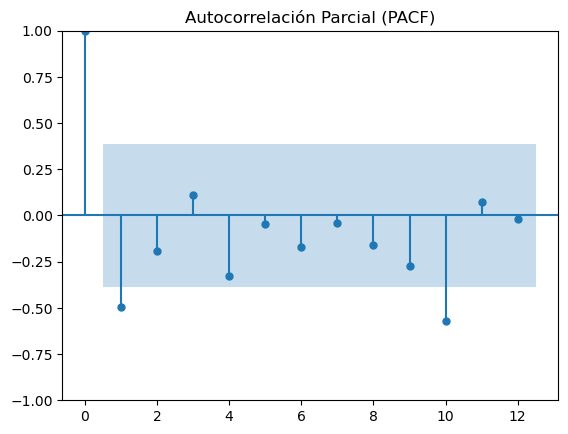

In [83]:
# Graficar la autocorrelación parcial (PACF)
plot_pacf(dif1, lags=12)
plt.title('Autocorrelación Parcial (PACF)')
plt.show()

- El lag 1 tiene una autocorrelación parcial muy alta (≈ 1), y los siguientes lags caen dentro de las bandas de confianza (zona azul), es decir, no son significativamente distintos de cero.

- Este patrón clásico es característico de una estructura AR(1).



In [84]:
# Modelo ARMA(3,2)
model = sm.tsa.ARIMA(dif1, order=(1, 0, 1))
result = model.fit()

# Mostrar los resultados
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:         total_facturas   No. Observations:                   26
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -225.259
Date:                Sat, 26 Apr 2025   AIC                            458.518
Time:                        00:34:08   BIC                            463.551
Sample:                             0   HQIC                           459.967
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8552     39.843     -0.122      0.903     -82.947      73.236
ar.L1          0.2182      0.232      0.940      0.347      -0.237       0.673
ma.L1         -0.9985      0.329     -3.032      0.0

# Verificación de Estacionalidad

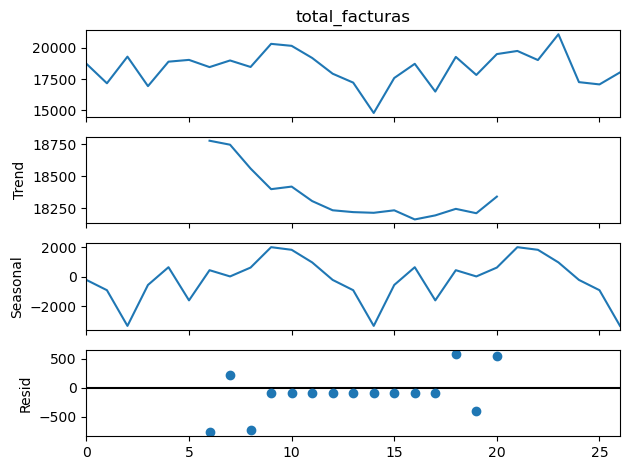

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['total_facturas'], model='additive', period=12)
result.plot()
plt.show()

- En **Trend (Tendencia)** se puede apreciar una tendencia negativa, con un ligero ascenso en los últimos periodos.
- En **Seasonal** también se aprecia una estacionalidad fuerte
- Los **residuos** no siguen un patrón claro, lo que indica ausencia de heterocedasticidad

# Prueba SARIMA

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['total_facturas'], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12))  # <- el 12 viene del patrón estacional
result = model.fit()
print(result.summary())

c:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                     total_facturas   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -128.770
Date:                            Sat, 26 Apr 2025   AIC                            267.540
Time:                                    00:34:09   BIC                            270.735
Sample:                                         0   HQIC                           267.244
                                             - 27                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5080      0.397     -1.280      0.201      -1.286       0.270
ma.L1          0.2818      0.443   

c:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- Ljung-Box (Q): p-valor 0.07 → aceptable (no hay mucha autocorrelación).
- Jarque-Bera (JB): p-valor 0.67 → residuos normales.
- Heteroskedasticidad: p-valor 0.69 → residuos homogéneos.

¡Los residuos son razonablemente ruido blanco! ✔️

# Forecast

**Diferencia Clave**
- Ver qué tan bien el modelo explica mis datos pasados:	**predict()**
- Predecir meses futuros que todavía no han pasado:	**get_forecast(steps=...)**

In [ ]:
# Predecir los próximos 12 pasos (12 meses)
forecast = result.get_forecast(steps=12)

# Obtener el intervalo de confianza
forecast_ci = forecast.conf_int()

# Mostrar predicciones
print(forecast.predicted_mean)

27    19745.296915
28    21077.071230
29    19076.952836
30    21452.719283
31    20238.798287
32    21615.089953
33    21973.870962
34    21245.369131
35    23131.730005
36    20561.083044
37    20359.388705
38    21155.249172
Name: predicted_mean, dtype: float64


In [ ]:
# Modificar

# Crear índice de fechas para histórico (27 meses)
fechas_historicas = pd.date_range(start='2021-01-01', periods=len(data), freq='MS')

# Crear índice de fechas para forecast (12 meses siguientes)
fechas_forecast = pd.date_range(start=fechas_historicas[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# Reasignar índices
data.index = fechas_historicas
forecast.predicted_mean.index = fechas_forecast
forecast_ci.index = fechas_forecast

In [91]:
# Obtener la predicción puntual
prediccion_central = forecast.predicted_mean

# Obtener límites del intervalo de confianza
pesimista = forecast_ci.iloc[:, 0]  # límite inferior
optimista = forecast_ci.iloc[:, 1]  # límite superior

# Crear un DataFrame juntando todo
df_forecast = pd.DataFrame({
    'Pesimista': pesimista,
    'Predicción': prediccion_central,
    'Optimista': optimista
})

# Mostrarlo
print(df_forecast)

       Pesimista    Predicción     Optimista
27  15095.646541  19745.296915  24394.947288
28  15196.624432  21077.071230  26957.518028
29  11889.266205  19076.952836  26264.639468
30  13293.009634  21452.719283  29612.428932
31  11151.433612  20238.798287  29326.162963
32  11714.291037  21615.089953  31515.888869
33  11308.484743  21973.870962  32639.257182
34   9872.879651  21245.369131  32617.858611
35  11090.927379  23131.730005  35172.532631
36   7896.224661  20561.083044  33225.941426
37   7099.100812  20359.388705  33619.676598
38   7325.135906  21155.249172  34985.362439


In [94]:
# Ajustar índices del forecast
# Si tu data tiene índices simples (0,1,2,3...) como en tu gráfico
start = data.index[-1] + 1  # último índice + 1
forecast_index = range(start, start + len(forecast.predicted_mean))

# Reasignar índices
forecast.predicted_mean.index = forecast_index
forecast_ci.index = forecast_index

In [98]:
data.index

RangeIndex(start=0, stop=27, step=1)

In [96]:
forecast_ci.index

RangeIndex(start=27, stop=39, step=1)

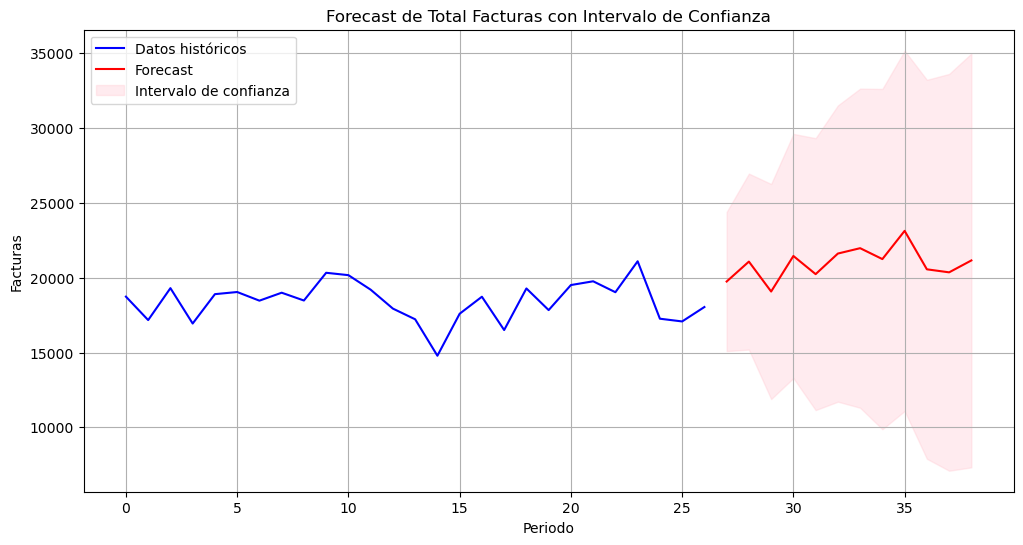

In [99]:
# Graficar
plt.figure(figsize=(12,6))

# Datos históricos
plt.plot(data.index, data['total_facturas'], label='Datos históricos', color='blue')

# Pronóstico puntual
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')

# Rellenar intervalo de confianza
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],  # Pesimista
                 forecast_ci.iloc[:, 1],  # Optimista
                 color='pink', alpha=0.3, label='Intervalo de confianza')

plt.legend()
plt.title('Forecast de Total Facturas con Intervalo de Confianza')
plt.xlabel('Periodo')
plt.ylabel('Facturas')
plt.grid(True)
plt.show()


In [89]:
data['total_facturas'].tail()

22    19031
23    21099
24    17260
25    17077
26    18041
Name: total_facturas, dtype: int64